In [46]:
import numpy as np
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [47]:
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
#phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [48]:
phoneHMMs["f"]

{'name': 'f',
 'startprob': array([1., 0., 0., 0.]),
 'transmat': array([[0.8437548, 0.1562452, 0.       , 0.       ],
        [0.       , 0.7090222, 0.2909778, 0.       ],
        [0.       , 0.       , 0.3064214, 0.6935785],
        [0.       , 0.       , 0.       , 1.       ]]),
 'means': array([[ 3.223918e+02, -2.714506e+02, -1.279559e+02,  4.936052e+01,
         -1.980236e+00, -9.977302e+00, -2.686330e+01, -4.009798e+01,
          3.357593e-01, -7.339875e+01,  2.645822e+01, -6.140060e+01,
          3.153127e+01],
        [ 4.886330e+02, -2.018883e+02, -1.998543e+02, -3.249403e+00,
         -1.454704e+01, -1.020947e+01, -5.742544e+01, -1.035629e+02,
         -2.134682e+01, -9.308153e+01,  2.632338e+01, -8.978764e+01,
          2.653858e+01],
        [ 5.815154e+02,  2.457827e+02,  2.437778e+01, -5.956849e+01,
         -1.490782e+02,  6.251358e+01, -1.867431e+01, -4.977795e+01,
          7.758113e+00,  1.062016e+02,  1.829358e+01,  2.677407e+01,
          1.664870e+01]]),
 'covars':

In [49]:
list(sorted(phoneHMMs.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [50]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

# 4

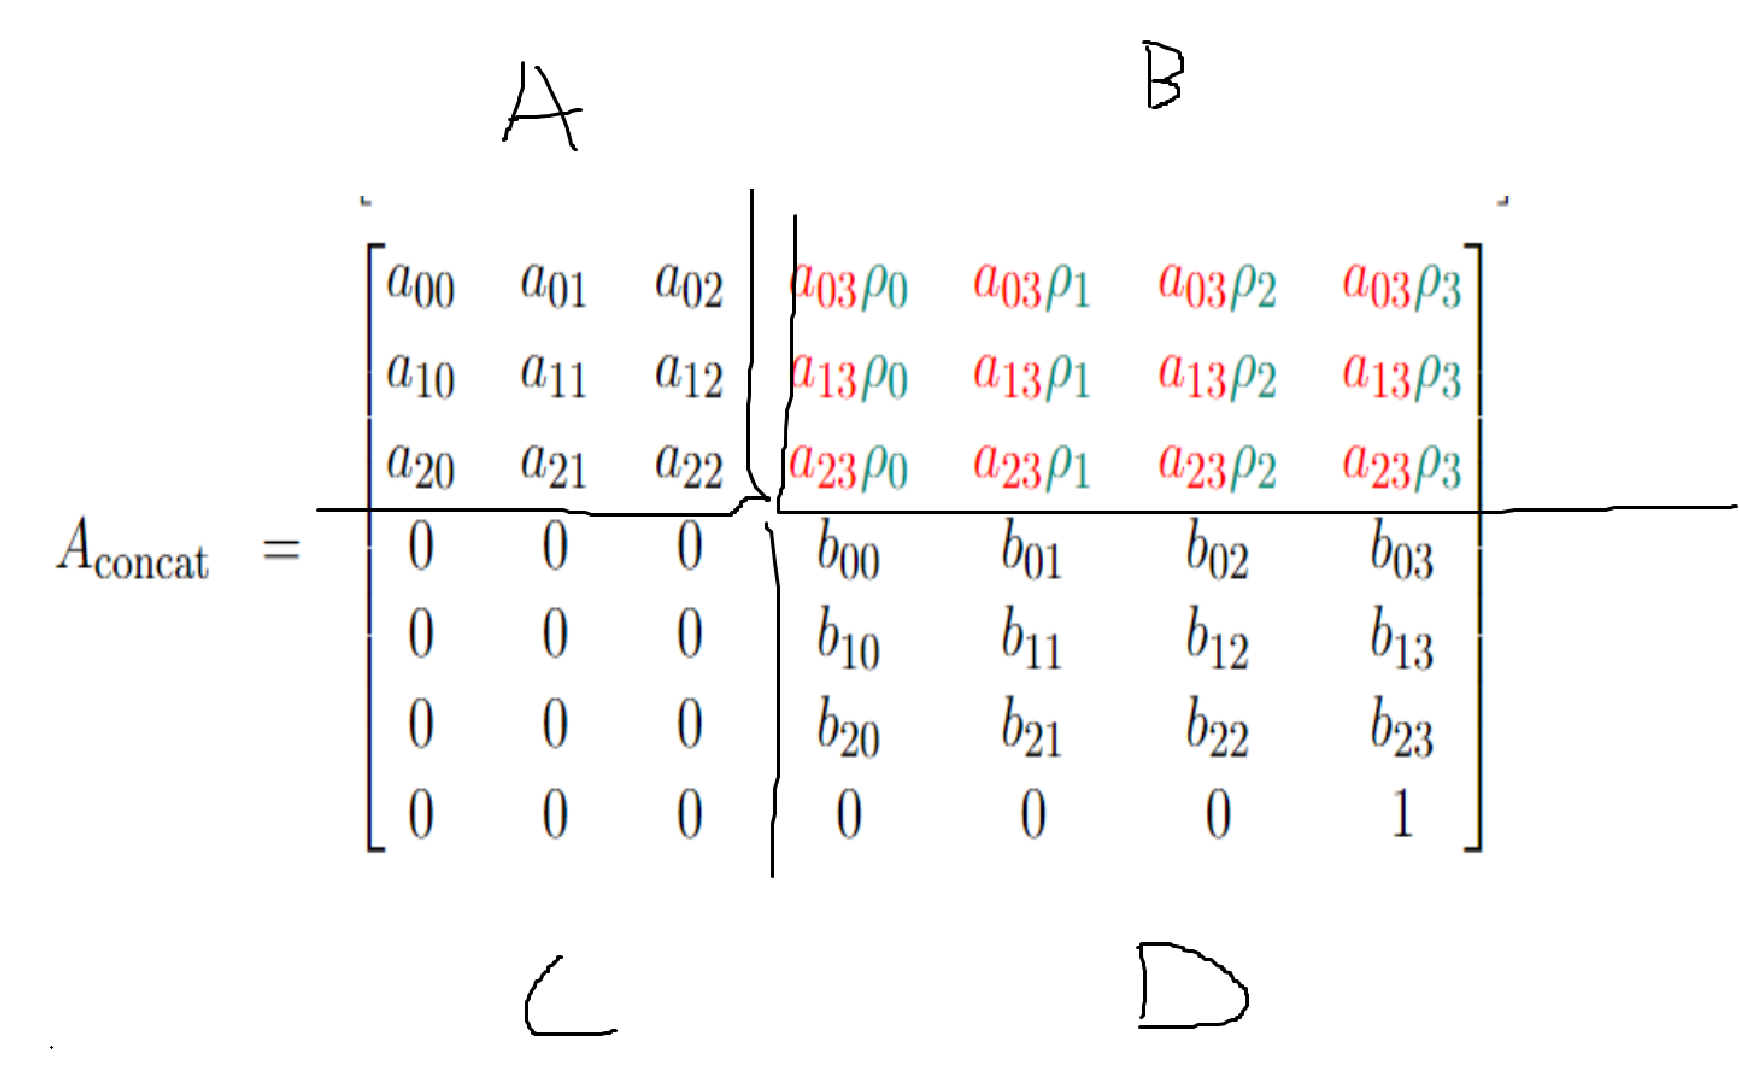

In [51]:
from lab2_proto import concatHMMs
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs, isolated['o'])

# 5

### 5.1

In [52]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

In [53]:
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

In [54]:
from lab2_tools import log_multivariate_normal_density_diag

In [55]:
X0 = example['lmfcc'] #71 "frames" of size 13, one datapoint
obsloglik=log_multivariate_normal_density_diag(X0,wordHMMs['o']["means"],wordHMMs['o']["covars"])
np.allclose(obsloglik,example['obsloglik'])

True

In [56]:
import matplotlib.pyplot as plt

def plot(data,xlabel="",ylabel="",title=""):
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(data, cmap='viridis')
    plt.colorbar(label='Value')
    #plt.xlim(0,400)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


In [57]:
#choose another data point
data[0]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': 'o',
 'repetition': 'a',
 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16),
 'lmfcc': array([[  64.7657709 ,  -65.84854216,   96.90766069, ...,  -19.82632821,
           11.63249931,  159.50790488],
        [  57.72402791,  -79.93732698,  105.80893583, ...,  -11.84501965,
          109.29701349,  138.79176124],
        [  62.16944867, -121.81014369,   61.89899215, ...,   13.28252915,
         -127.7140298 , -128.75563442],
        ...,
        [ 190.29491187,   97.34488369,  175.61357289, ...,  -62.63035172,
          138.96640354,   82.95734165],
        [ 201.37123403,   80.09496653,   50.98133557, ...,  219.16711476,
           94.41131525, -100.10312668],
        [ 194.17067167,   70.85205455,   40.456538  , ...,   -3.81053312,
          143.83615904,  -42.56212766]])}

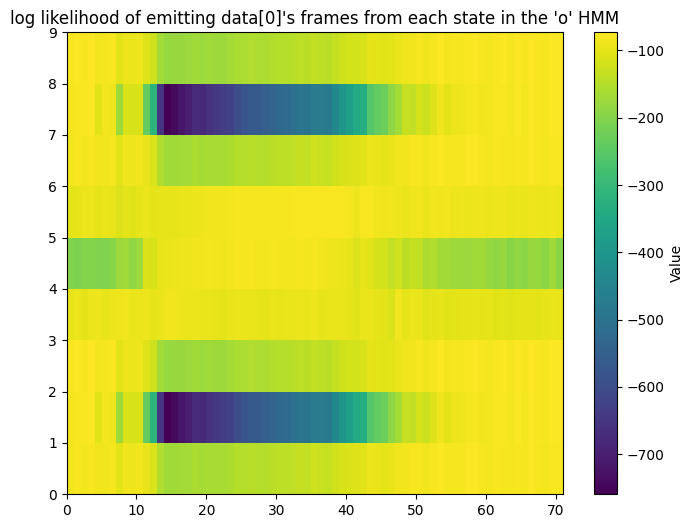

In [83]:
#calculate log likelihood of the datapoint and plot that
X1 = example['lmfcc']
log_likelihoods=log_multivariate_normal_density_diag(X1,wordHMMs['o']["means"],wordHMMs['o']["covars"])
plot(log_likelihoods.T,title="log likelihood of emitting data[0]'s frames from each state in the 'o' HMM")

### 5.2

In [59]:
from lab2_tools import logsumexp
def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik (B):NxM array of emission log likelihoods, N frames (timesteps), M states
        log_startprob (pi): M array log probability to start in state i
        log_transmat (A): M+1xM+1 array log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    #j enumerates states
    N,M = log_emlik.shape

    #alpha in the log domain technically "logalpha"
    alpha = -np.inf * np.ones((N,M))

    #first row of alpha
    for j in range(M):
        alpha[0,j] = log_startprob[j]+log_emlik[0,j]
        #log_emlik[i,j]=log phi_j(x_i)
        #we want log phi_j(x_o) => log_emlik[0,j]
    #all other rows
    for n in range(1,N):
        for j in range(0,M):
            #log_transmat[:-1,j]) because it includes transitions to the non-emitting final state which we dont want
            alpha[n,j]=logsumexp(alpha[n-1,:]+log_transmat[:-1,j])+log_emlik[n,j]
    return alpha

In [60]:
fwd=forward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))

C:\Users\A\AppData\Local\Temp\ipykernel_15828\3462415292.py:1: RuntimeWarning: divide by zero encountered in log
  fwd=forward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))


In [61]:
np.allclose(fwd,example['logalpha'])


True

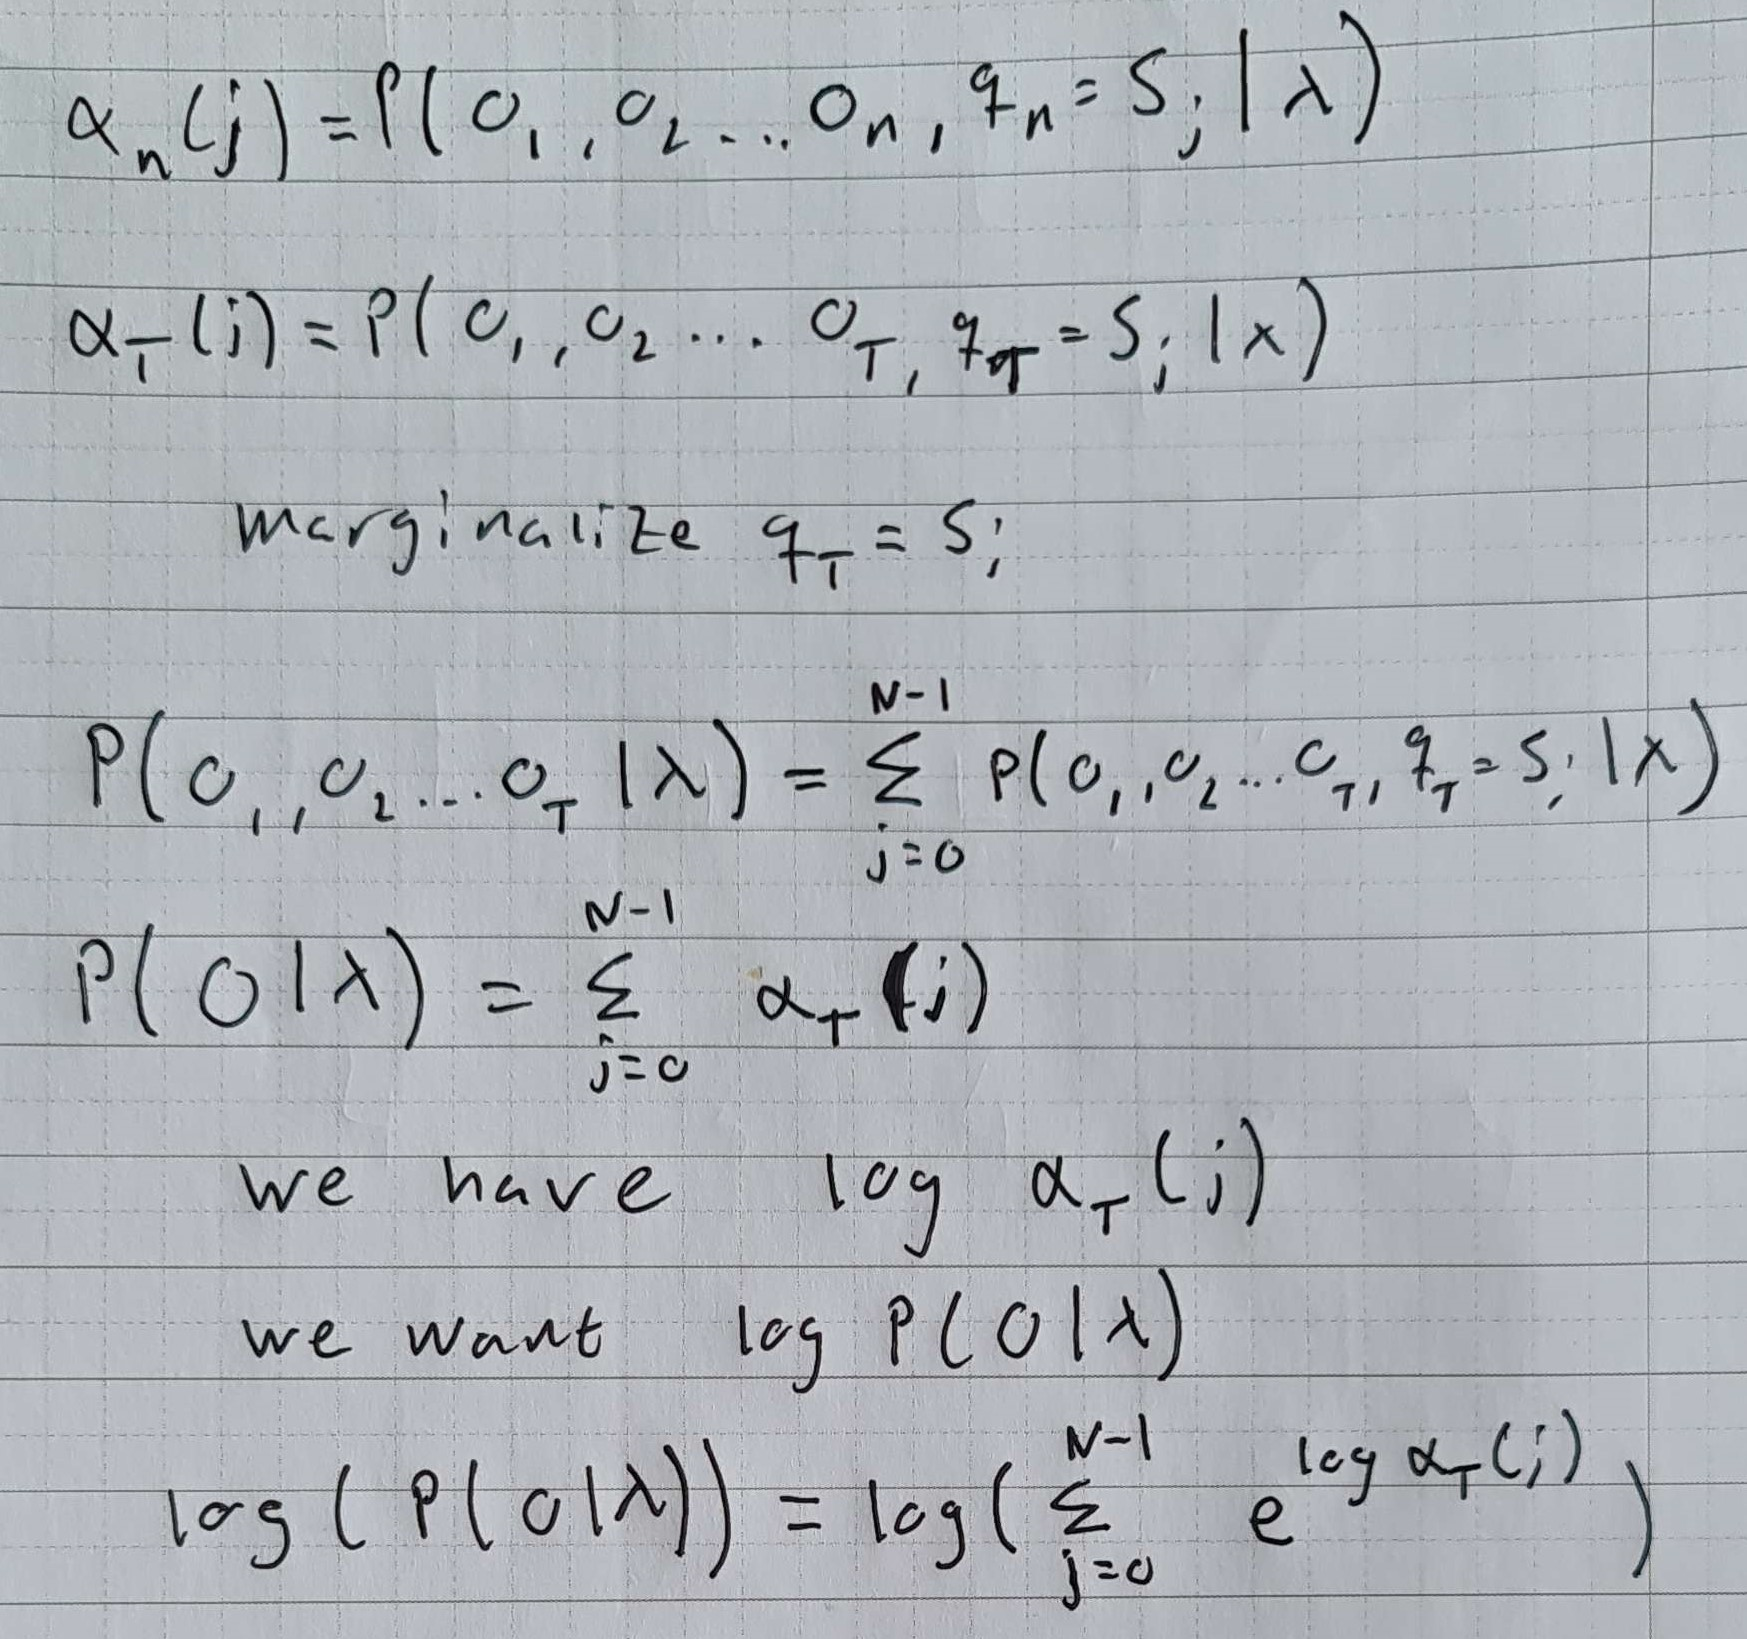

In [62]:
from lab2_tools import logsumexp
loglik=logsumexp(fwd[-1,:])
np.allclose(loglik,example['loglik'])

True

each of the 44 utterances

In [63]:
def hmmind_2_uttr(arr):
    out = []
    for i in arr:
        out.append(hmmind_2_uttr_help(i))
    return out

def hmmind_2_uttr_help(x):
    if x== 0:
        return "o"
    elif x==1:
        return "z"
    return str(x-1)

C:\Users\A\AppData\Local\Temp\ipykernel_15828\2023487380.py:14: RuntimeWarning: divide by zero encountered in log
  fwd=forward(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]))


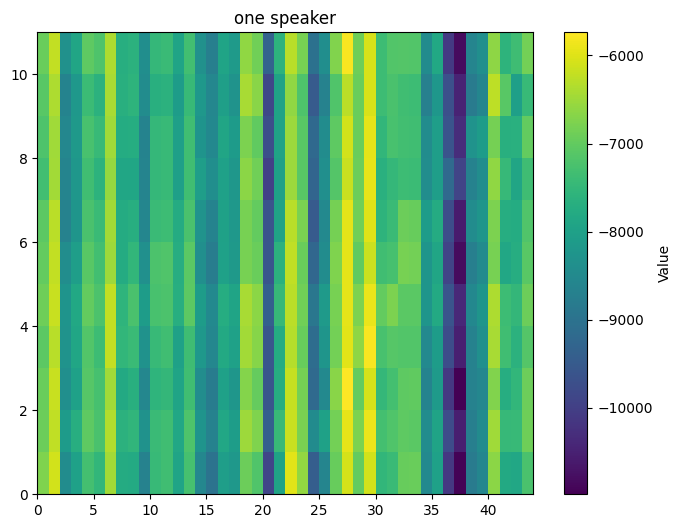

predicted class based on highest HMM activation
['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
actual class
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
accuracy: 0.7727272727272727


In [64]:
#one speaker
HMMs = {}
phoneHMM_one_speaker = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
for wordKey in isolated:
        HMMs[wordKey] = concatHMMs(phoneHMM_one_speaker, isolated[wordKey])

data_matrix = np.zeros((len(HMMs),len(data)))
#run each HMM on each datapoint
for h,hmmKey in enumerate(HMMs):
    HMM = HMMs[hmmKey]
    for d,datapoint in enumerate(data):
        Xn = datapoint["lmfcc"]
        log_likelihoods=log_multivariate_normal_density_diag(Xn,HMM["means"],HMM["covars"])
        fwd=forward(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
        loglik=logsumexp(fwd[-1,:])
        data_matrix[h,d] = loglik
plot(data_matrix,title="one speaker")
print("predicted class based on highest HMM activation")
pred_fwd_1 = hmmind_2_uttr(np.argmax(data_matrix,axis=0))
print(pred_fwd_1)
ground_truth = []
for d in data:
    ground_truth.append(d["digit"])
print("actual class")
print(ground_truth)
print(f"accuracy: {np.mean(np.array(ground_truth)==np.array(pred_fwd_1))}")

C:\Users\A\AppData\Local\Temp\ipykernel_15828\1119822309.py:14: RuntimeWarning: divide by zero encountered in log
  fwd=forward(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]))


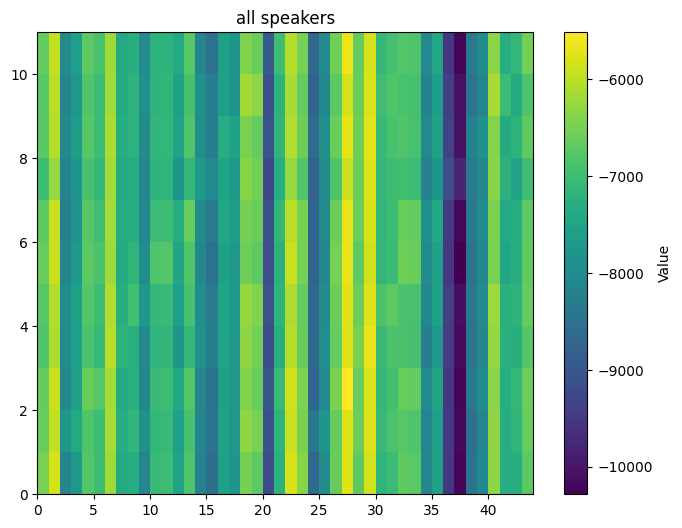

predicted class based on highest HMM activation
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '1', '9']
actual class
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
accuracy: 0.9772727272727273


In [65]:
#all speakers
HMMs = {}
phoneHMM_all_speakers = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
for wordKey in isolated:
        HMMs[wordKey] = concatHMMs(phoneHMM_all_speakers, isolated[wordKey])

data_matrix = np.zeros((len(HMMs),len(data)))
#run each HMM on each datapoint
for h,hmmKey in enumerate(HMMs):
    HMM = HMMs[hmmKey]
    for d,datapoint in enumerate(data):
        Xn = datapoint["lmfcc"]
        log_likelihoods=log_multivariate_normal_density_diag(Xn,HMM["means"],HMM["covars"])
        fwd=forward(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
        loglik=logsumexp(fwd[-1,:])
        data_matrix[h,d] = loglik
plot(data_matrix,title="all speakers")
print("predicted class based on highest HMM activation")
pred_fwd_2 = hmmind_2_uttr(np.argmax(data_matrix,axis=0))
print(pred_fwd_2)
ground_truth = []
for d in data:
    ground_truth.append(d["digit"])
print("actual class")
print(ground_truth)
print(f"accuracy: {np.mean(np.array(ground_truth)==np.array(pred_fwd_2))}")

## 5.3

In [66]:
def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """

    N,M = log_emlik.shape

    #alpha in the log domain technically "logalpha"
    V = -np.inf * np.ones((N,M))
    B = -np.inf * np.ones((N,M)) 

    #first row of V and B 
    for j in range(M):
        V[0,j] = log_startprob[j]+log_emlik[0,j]
        B[0,j] = -np.inf

    for n in range(1,N):
        for j in range(0,M):
            V[n,j] = np.max(V[n-1,:]+log_transmat[:-1,j])+log_emlik[n,j]
            B[n,j] = np.argmax(V[n-1,:]+log_transmat[:-1,j]) 

    viterbi_loglik = max(V[-1,:])
    if forceFinalState:
        sT = M-1
    else: 
        sT = np.argmax(B[-1,:]) 

    #print(pd.DataFrame(V))
    viterbi_path = np.zeros(N,dtype=np.int64) 
    viterbi_path[-1] = sT

    #backing 
    for n in range(N-2,-1,-1): #-1 in the middle because range excludes the last value
        viterbi_path[n] = B[n+1,viterbi_path[n+1]]  

    return viterbi_loglik, viterbi_path 


In [67]:
X0 = example['lmfcc'] #71 "frames" of size 13, one datapoint
obsloglik=log_multivariate_normal_density_diag(X0,wordHMMs['o']["means"],wordHMMs['o']["covars"])
np.allclose(obsloglik,example['obsloglik'])
fwd=forward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))

vit_loglik,vit_path = viterbi(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]),True)
np.allclose(example['vloglik'],vit_loglik)

C:\Users\A\AppData\Local\Temp\ipykernel_15828\2226887936.py:4: RuntimeWarning: divide by zero encountered in log
  fwd=forward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))
C:\Users\A\AppData\Local\Temp\ipykernel_15828\2226887936.py:6: RuntimeWarning: divide by zero encountered in log
  vit_loglik,vit_path = viterbi(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]),True)


True

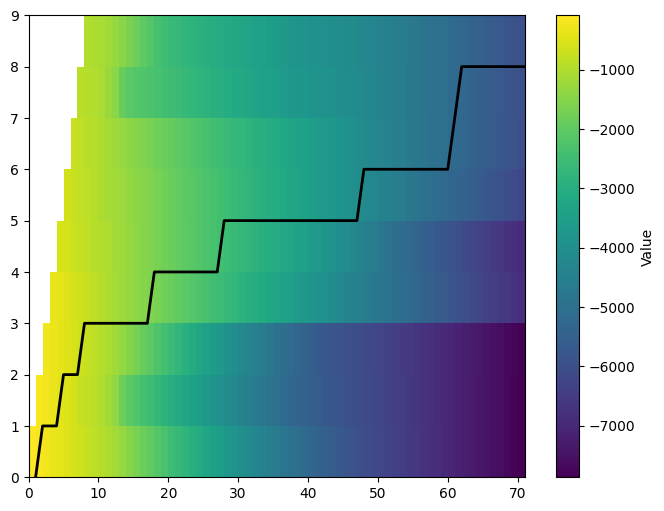

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

# Create indices for plotting
indices = np.arange(vit_path.size)+1

# Combine indices and values into vertices for the path
vertices = np.stack((indices, vit_path), axis=1)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Create pcolormesh
c = ax.pcolormesh(fwd.T, cmap='viridis')
fig.colorbar(c, ax=ax, label='Value')

# Add the path patch to the axes
#ax.add_patch(patch)
plt.plot(indices, vit_path, linewidth=2,color="black")
plt.show()


it choses the max value in each column while still being able to transition - "avoids the cold spots"

C:\Users\A\AppData\Local\Temp\ipykernel_15828\3061522797.py:14: RuntimeWarning: divide by zero encountered in log
  score,path=viterbi(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]),False)


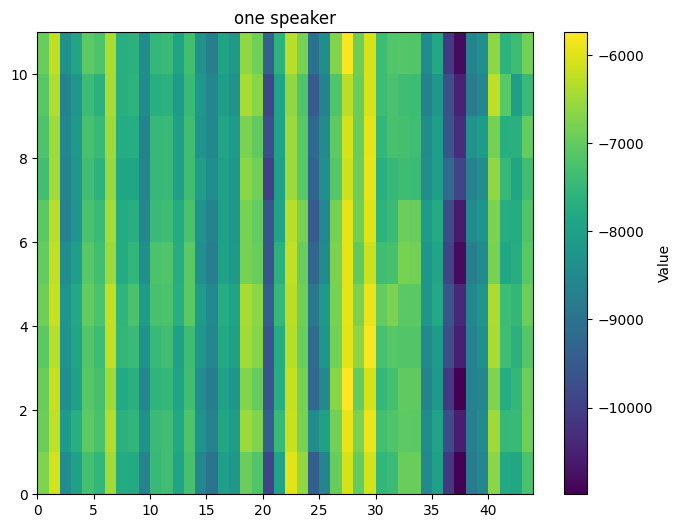

predicted class based on highest HMM activation
['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
actual class
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
accuracy: 0.7727272727272727


In [69]:
#one speaker
HMMs = {}
phoneHMM_one_speaker = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
for wordKey in isolated:
        HMMs[wordKey] = concatHMMs(phoneHMM_one_speaker, isolated[wordKey])

data_matrix = np.zeros((len(HMMs),len(data)))
#run each HMM on each datapoint
for h,hmmKey in enumerate(HMMs):
    HMM = HMMs[hmmKey]
    for d,datapoint in enumerate(data):
        Xn = datapoint["lmfcc"]
        log_likelihoods=log_multivariate_normal_density_diag(Xn,HMM["means"],HMM["covars"])
        score,path=viterbi(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]),False)
        data_matrix[h,d] = score
plot(data_matrix,title="one speaker")
print("predicted class based on highest HMM activation")
pred_vit_1 = hmmind_2_uttr(np.argmax(data_matrix,axis=0))
print(pred_vit_1)
ground_truth = []
for d in data:
    ground_truth.append(d["digit"])
print("actual class")
print(ground_truth)
print(f"accuracy: {np.mean(np.array(ground_truth)==np.array(pred_vit_1))}")

C:\Users\A\AppData\Local\Temp\ipykernel_15828\486646066.py:14: RuntimeWarning: divide by zero encountered in log
  score,path=viterbi(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]))


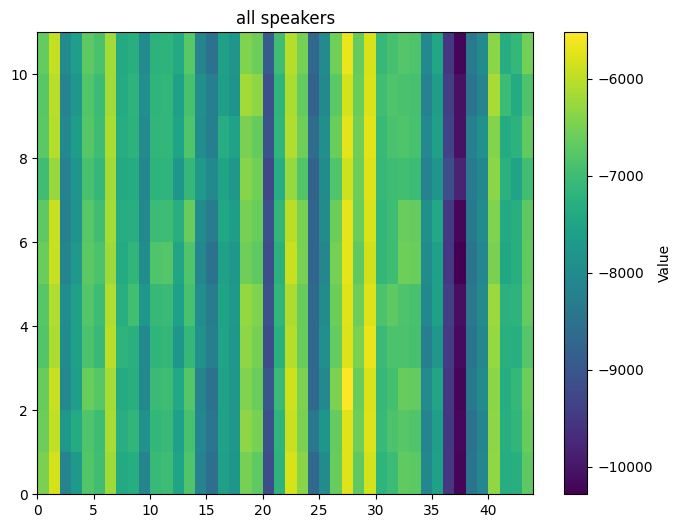

predicted class based on highest HMM activation
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
actual class
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
accuracy: 1.0


In [70]:
#all speakers
HMMs = {}
phoneHMM_all_speakers = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
for wordKey in isolated:
        HMMs[wordKey] = concatHMMs(phoneHMM_all_speakers, isolated[wordKey])

data_matrix = np.zeros((len(HMMs),len(data)))
#run each HMM on each datapoint
for h,hmmKey in enumerate(HMMs):
    HMM = HMMs[hmmKey]
    for d,datapoint in enumerate(data):
        Xn = datapoint["lmfcc"]
        log_likelihoods=log_multivariate_normal_density_diag(Xn,HMM["means"],HMM["covars"])
        score,path=viterbi(log_likelihoods,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
        data_matrix[h,d] = score
plot(data_matrix,title="all speakers")
print("predicted class based on highest HMM activation")
pred_vit_2 = hmmind_2_uttr(np.argmax(data_matrix,axis=0))
print(pred_vit_2)
ground_truth = []
for d in data:
    ground_truth.append(d["digit"])
print("actual class")
print(ground_truth)
print(f"accuracy: {np.mean(np.array(ground_truth)==np.array(pred_vit_2))}")

viterbi is around 2x faster than forward

In [71]:
#compare mistakes
print(pred_fwd_1)
print(pred_fwd_2)
print(pred_vit_1)
print(pred_vit_2)
#print(ground_truth)

['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '1', '9']
['o', 'o', 'z', 'z', '3', '9', '3', '2', '3', '3', '4', '4', '3', '3', '6', '6', '3', '3', '3', '3', '9', 'z', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
['o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', 'o', 'o', 'z', 'z', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']


## 5.4 backward algorithm

In [72]:
def backward(log_emlik, log_startprob, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """

    #j enumerates states
    N,M = log_emlik.shape

    #beta in the log domain technically "logbeta"
    beta = -np.inf * np.ones((N,M))

    #first row of beta
    for j in range(M):
        beta[N-1,j] = 0

    #all other rows
    for n in range(N-2,-1,-1):
        for i in range(0,M):
            #log_transmat[:-1,j]) because it includes transitions to the non-emitting final state which we dont want
            beta[n,i]=logsumexp(log_transmat[i,:-1]+log_emlik[n+1,:]+beta[n+1,:])
    return beta

C:\Users\A\AppData\Local\Temp\ipykernel_15828\942054362.py:4: RuntimeWarning: divide by zero encountered in log
  logbeta = backward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))


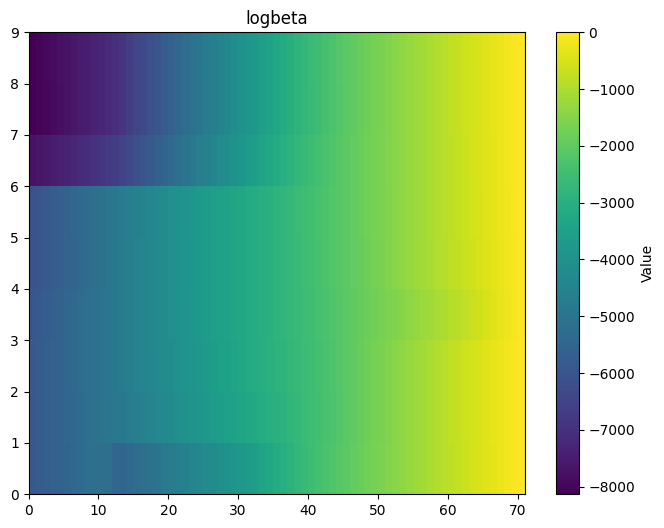

In [73]:
X0 = example['lmfcc'] #71 "frames" of size 13, one datapoint
obsloglik=log_multivariate_normal_density_diag(X0,wordHMMs['o']["means"],wordHMMs['o']["covars"])

logbeta = backward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))
np.allclose(example['logbeta'],logbeta)
plot(logbeta.T,title="logbeta")

# 6

## 6.1 state posteriors

In [74]:
from lab2_tools import logsumexp

def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    
    N,M = log_alpha.shape
    
    gamma = np.zeros((N,M))
    
    for n in range(N):
        for i in range(M):
            gamma[n,i] = log_alpha[n,i]+log_beta[n,i]-logsumexp(log_alpha[N-1,:])
    return gamma

In [75]:
X0 = example['lmfcc'] #71 "frames" of size 13, one datapoint
obsloglik=log_multivariate_normal_density_diag(X0,wordHMMs['o']["means"],wordHMMs['o']["covars"])

log_alpha=forward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))
log_beta=backward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))
state_post = statePosteriors(log_alpha,log_beta)
hmm_posterior = np.exp(state_post)

C:\Users\A\AppData\Local\Temp\ipykernel_15828\321224384.py:4: RuntimeWarning: divide by zero encountered in log
  log_alpha=forward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))
C:\Users\A\AppData\Local\Temp\ipykernel_15828\321224384.py:5: RuntimeWarning: divide by zero encountered in log
  log_beta=backward(obsloglik,np.log(wordHMMs['o']["startprob"]),np.log(wordHMMs["o"]["transmat"]))


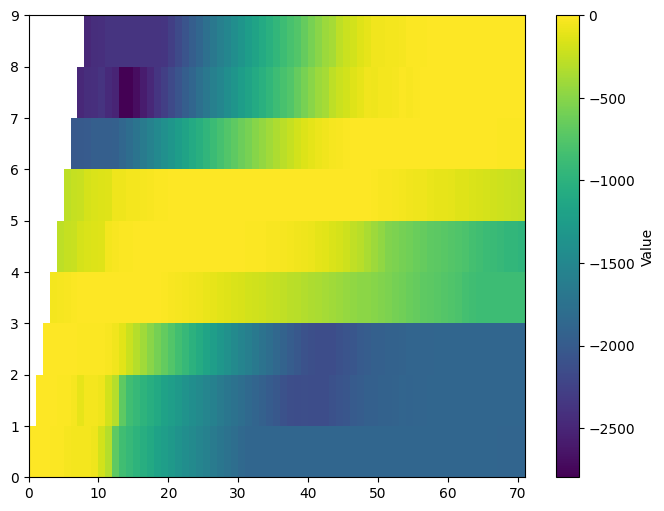

In [76]:
plot(state_post.T)

In [77]:
np.allclose(np.exp(state_post).sum(axis=1), 1)

True

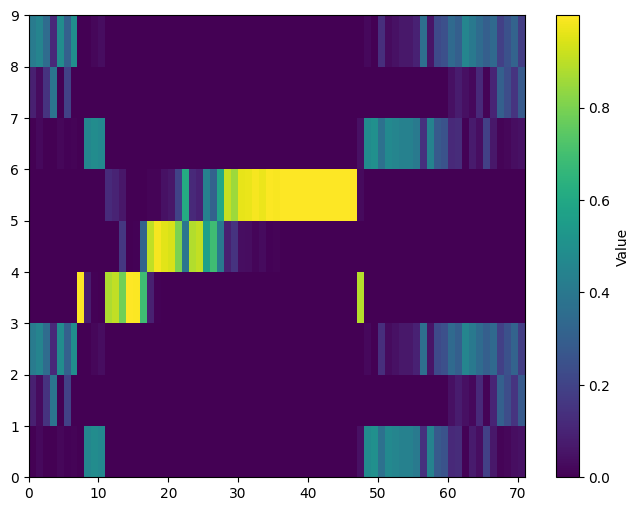

In [78]:

#normalize in the log domain
log_prob_norm = obsloglik - np.expand_dims(logsumexp(obsloglik, axis=1),axis=1)
#get it back to the linear domain
gmm_posterior = np.exp(log_prob_norm)

#pd.DataFrame(np.round(gmm_posterior,2)),pd.DataFrame(np.round(hmm_posterior,2))
plot(gmm_posterior.T)

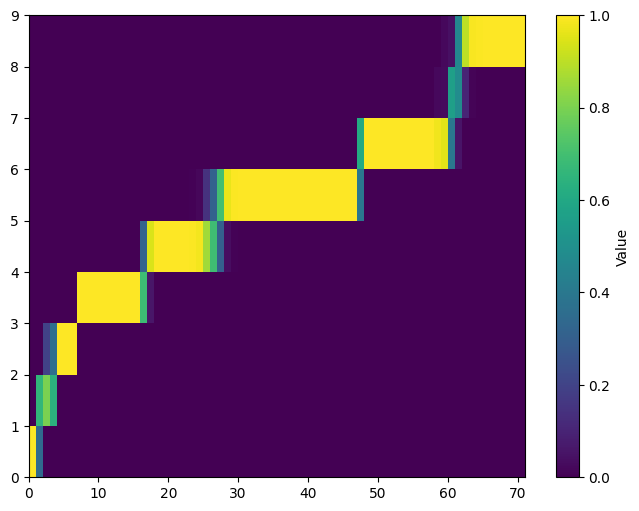

In [79]:
plot(hmm_posterior.T)

The general pattern is somewhat similar but in the HMM case they are contigous, since we dont allow transitions between two non-consecutive states which is perfectly fine in the GMM case (thereby the smattering between states)

In [80]:
print("time axis")
print(hmm_posterior.sum(axis=1))
print("both axes")
print(np.sum(hmm_posterior))

time axis
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
both axes
70.99999999991067


we get 1 on each time axis because its a posterior so they need to sum to 1. The reason that it doesnt quite sum to 71 is because of rounding error in python?

## 6.2

In [81]:
def updateMeanAndVar_old(X, log_gamma, varianceFloor=5.0):
     """ Update Gaussian parameters with diagonal covariance

    Args:
         X: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         varianceFloor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """

     N,M = log_gamma.shape
     D = X.shape[1] 

     #given a sequence of feature vectors and the array of state posteriors probabilities, 
     #estimates the new mean and variance vectors for ->>> each state 

     log_means_star = np.zeros((M,D))
     log_covars_star = np.zeros((M,D))
     for i in range(M):#   
          log_gamma_rshp = log_gamma[:,i].reshape(-1, 1)                      
          log_means_star[i,:] = np.sum(log_gamma_rshp * X) - np.sum(log_gamma[:,i])
          log_covars_star[i,:] = np.sum(log_gamma_rshp*(X-log_means_star[i,:])@(X-log_means_star[i,:]).T) - np.sum(log_gamma[:,i])
          #print((X-log_means_star[i,:])**2)
     #substitute any value below varianceFloor with varianceFloor
     log_covars_star[log_covars_star < varianceFloor] = varianceFloor
     return log_means_star, log_covars_star

import numpy as np

def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
    """Update Gaussian parameters with diagonal covariance

    Args:
        X: NxD array of feature vectors
        log_gamma: NxM state posterior probabilities in log domain
        varianceFloor: minimum allowed variance scalar
    were N is the length of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
        means: MxD mean vectors for each state
        covars: MxD covariance (variance) vectors for each state
    """
    N, M = log_gamma.shape
    D = X.shape[1]

    gamma = np.exp(log_gamma)  # Convert log probabilities to probabilities
    means = np.zeros((M, D))
    covars = np.zeros((M, D))

    for i in range(M):
        # Weighted sums for means
        weights = gamma[:, i].reshape(-1, 1)  # Reshape for broadcasting
        means[i, :] = np.sum(weights * X, axis=0) / np.sum(weights, axis=0)

        # Weighted sums for covariances
        diffs = X - means[i, :]
        covars[i, :] = np.sum(weights * diffs**2, axis=0) / np.sum(weights, axis=0)

    # Apply variance floor
    covars[covars < varianceFloor] = varianceFloor

    return means, covars

In [82]:
MAX_ITERATIONS = 20
X = data[10]["lmfcc"]
print("Speaker says: " + str(data[10]["digit"]))
for i in range(6):
    HMM = HMMs[list(HMMs.keys())[i]]#wordHMMs['o']
    print("\n\n"+HMM["name"])

    
    means = HMM["means"]
    covars = HMM["covars"]

    i=0
    prev_likelihood = -np.inf
    delta_likelihood = np.inf

    while i < MAX_ITERATIONS:
        #1)
        obsloglik=log_multivariate_normal_density_diag(X,means, covars)
        log_alpha=forward(obsloglik,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
        loglik=logsumexp(log_alpha[-1,:])
        log_beta=backward(obsloglik,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
        log_gamma = statePosteriors(log_alpha,log_beta)
        #hmm_posterior = np.sum(log_gamma)
        #2)
        means,covars = updateMeanAndVar(X,log_gamma)
        
        #3)
        obsloglik=log_multivariate_normal_density_diag(X,means, covars)
        log_alpha_new=forward(obsloglik,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
        loglik_new=logsumexp(log_alpha_new[-1,:])
        print(loglik_new - loglik)
        if(loglik_new - loglik) < 1:
            break
        #print(np.sum(means),np.sum(covars))
        i+=1

Speaker says: 4


sil_ow_sil
618.8755182467194
98.76864614815713
31.02777803914796
2.6846964132655557
0.003289892758402857


sil_z_iy_r_ow_sil


C:\Users\A\AppData\Local\Temp\ipykernel_15828\16587548.py:19: RuntimeWarning: divide by zero encountered in log
  log_alpha=forward(obsloglik,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
C:\Users\A\AppData\Local\Temp\ipykernel_15828\16587548.py:21: RuntimeWarning: divide by zero encountered in log
  log_beta=backward(obsloglik,np.log(HMM["startprob"]),np.log(HMM["transmat"]))
C:\Users\A\AppData\Local\Temp\ipykernel_15828\16587548.py:29: RuntimeWarning: divide by zero encountered in log
  log_alpha_new=forward(obsloglik,np.log(HMM["startprob"]),np.log(HMM["transmat"]))


1126.220730496132
157.40203759970154
22.262985205197765
4.348197423063539
0.00019143579265801236


sil_w_ah_n_sil
851.0183167008299
193.66339856672948
40.916728014623914
27.12883362523644
9.543579577217315
4.6235334461625825
2.84382853619627
5.992933163028283
2.472752172705441
-3.637978807091713e-12


sil_t_uw_sil
783.8151375884663
162.2530570849067
26.971051258592524
20.089972957642203
0.19111967133812868


sil_th_r_iy_sil
902.638450866757
139.00590240380916
42.69306195446643
0.0006478421009887825


sil_f_ao_r_sil
672.0585572535329
132.07092343197291
24.367567241389224
4.108225254340141
8.919505489757285e-08
